# Muon vs. AdamW Experiment Analysis

This notebook analyzes the results of the OMat24 experiments, comparing the performance and learning geometry of the Muon optimizer against AdamW.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Robust Data Loading for a Mixed-Format CSV ---
# This block is designed to handle the messy metrics.csv file, which contains
# a mix of old and new data from different experimental runs.

try:
    # Define the correct header for our new, complete data
    CORRECT_HEADER = [
        "run", "epoch", "train_loss", "train_mae", "val_mae", "val_rmse",
        "val_mae_low_rattle", "val_mae_medium_rattle", "val_mae_high_rattle"
    ]

    # Read the raw lines from the file
    with open('results/metrics.csv', 'r') as f:
        lines = f.readlines()

    # Find the index of the first line that is part of our new, valid runs
    # We know the new runs have 9 columns, and the run name is not a number
    first_good_row_index = -1
    for i, line in enumerate(lines):
        parts = line.strip().split(',')
        if len(parts) == len(CORRECT_HEADER) and not parts[0].isdigit():
            first_good_row_index = i
            break

    if first_good_row_index == -1:
        raise ValueError("Could not find any valid data rows from the new experiments.")

    print(f"Found start of valid data at line {first_good_row_index + 1}.")

    # Re-read the CSV, skipping all the old/bad rows and applying the correct header
    df_full = pd.read_csv(
        'results/metrics.csv', 
        skiprows=first_good_row_index, 
        names=CORRECT_HEADER,
        header=None # We are providing our own names
    )

    print("\nData loaded and cleaned successfully.")
    display(df_full.head())
    print("\nFinal epoch metrics for each run:")
    display(df_full.groupby('run').last())

except FileNotFoundError:
    print("Error: results/metrics.csv not found.")
    print("Please make sure you have downloaded the results from the GPU.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Set plot style
sns.set_theme(style="whitegrid")


Found start of valid data at line 126.

Data loaded and cleaned successfully.


,run,epoch,train_loss,train_mae,val_mae,val_rmse,val_mae_low_rattle,val_mae_medium_rattle,val_mae_high_rattle
0,omat24_smoketest,1,6.886211,2.105387,1.477329,1.778038,1.477329,0.0,0.0
1,omat24_baseline,1,1.126236,0.686569,0.343478,0.445603,0.343478,0.0,0.0
2,omat24_baseline,2,0.178212,0.324198,0.308581,0.394142,0.308581,0.0,0.0
3,omat24_baseline,3,0.086634,0.227379,0.163071,0.215340,0.163071,0.0,0.0
4,omat24_baseline,4,0.066448,0.197219,0.152983,0.201438,0.152983,0.0,0.0



Final epoch metrics for each run:


,epoch,train_loss,train_mae,val_mae,val_rmse,val_mae_low_rattle,val_mae_medium_rattle,val_mae_high_rattle
run,,,,,,,,
omat24_baseline,40,0.003511,0.045911,0.097908,0.130843,0.097908,0.0,0.0
omat24_muon,40,0.023161,0.114923,0.164606,0.208952,0.164606,0.0,0.0
omat24_muon_firstk,40,0.004116,0.049414,0.090074,0.121243,0.090074,0.0,0.0
omat24_muon_no_ortho,40,0.023265,0.115580,0.121359,0.161372,0.121359,0.0,0.0
omat24_smoketest,1,6.886211,2.105387,1.477329,1.778038,1.477329,0.0,0.0


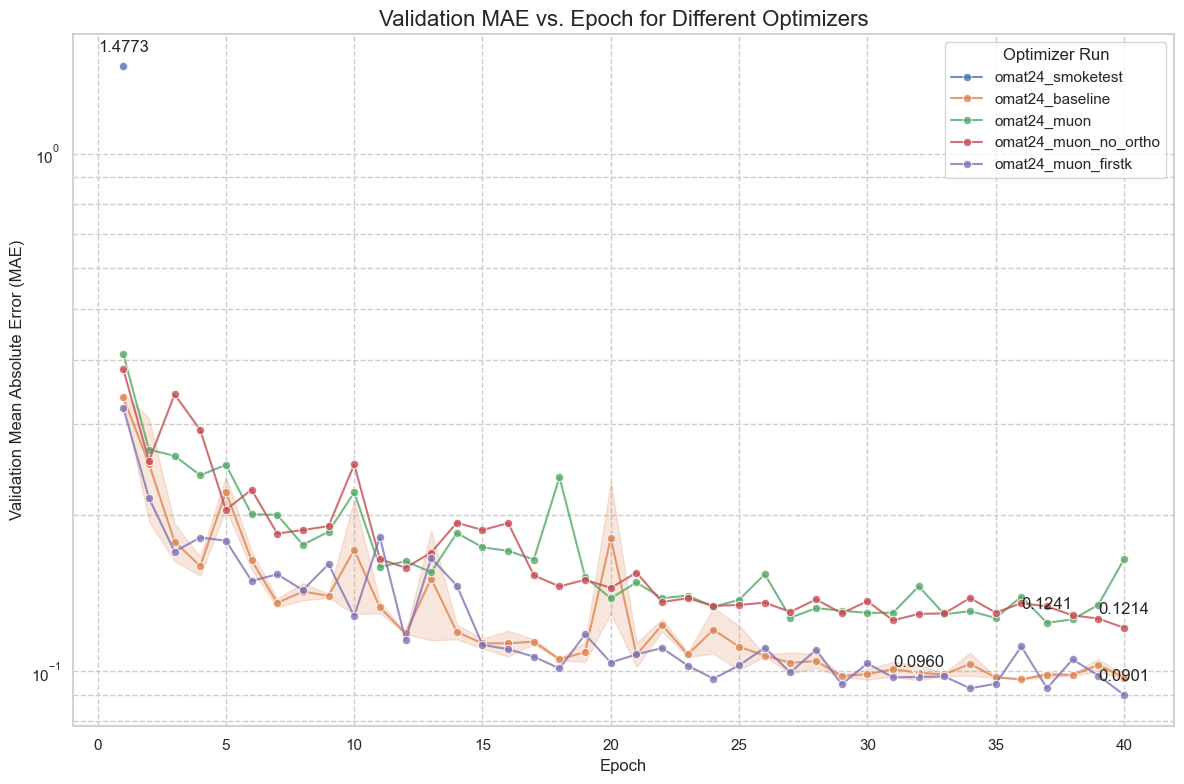

In [3]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=df_full, x='epoch', y='val_mae', hue='run', marker='o', alpha=0.8)

ax.set_title('Validation MAE vs. Epoch for Different Optimizers', fontsize=16)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation Mean Absolute Error (MAE)', fontsize=12)
ax.legend(title='Optimizer Run')
ax.set_yscale('log')
ax.grid(True, which="both", ls="--")


# Annotate the minimum MAE for each run
for run_name in df_full['run'].unique():
    run_df = df_full[df_full['run'] == run_name].dropna(subset=['val_mae'])
    if not run_df.empty:
        min_mae_row = run_df.loc[run_df['val_mae'].idxmin()]
        
        plt.annotate(f'{min_mae_row["val_mae"]:.4f}',
                     (min_mae_row['epoch'], min_mae_row['val_mae']),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center',
                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

plt.tight_layout()
plt.show()


In [4]:
# Manually create a DataFrame with the final test set results from the eval script
test_results = {
    "run": [
        "omat24_baseline",
        "omat24_muon_full",
        "omat24_muon_no_ortho",
        "omat24_muon_firstk",
    ],
    "Final Test MAE": [0.3296, 0.4087, 0.3844, 0.3238],
    "Final Test RMSE": [0.4183, 0.5095, 0.4737, 0.4107],
}
df_test = pd.DataFrame(test_results)

print("--- Final Test Set Performance ---")
# Sort by the most important metric to see the winner clearly
display(df_test.sort_values("Final Test MAE"))


--- Final Test Set Performance ---


,run,Final Test MAE,Final Test RMSE
3,omat24_muon_firstk,0.3238,0.4107
0,omat24_baseline,0.3296,0.4183
2,omat24_muon_no_ortho,0.3844,0.4737
1,omat24_muon_full,0.4087,0.5095


/var/folders/nb/ndd6gvxs6_gbvb_k01kc7kwh0000gn/T/ipykernel_42150/3632680256.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_test.sort_values("Final Test MAE"),


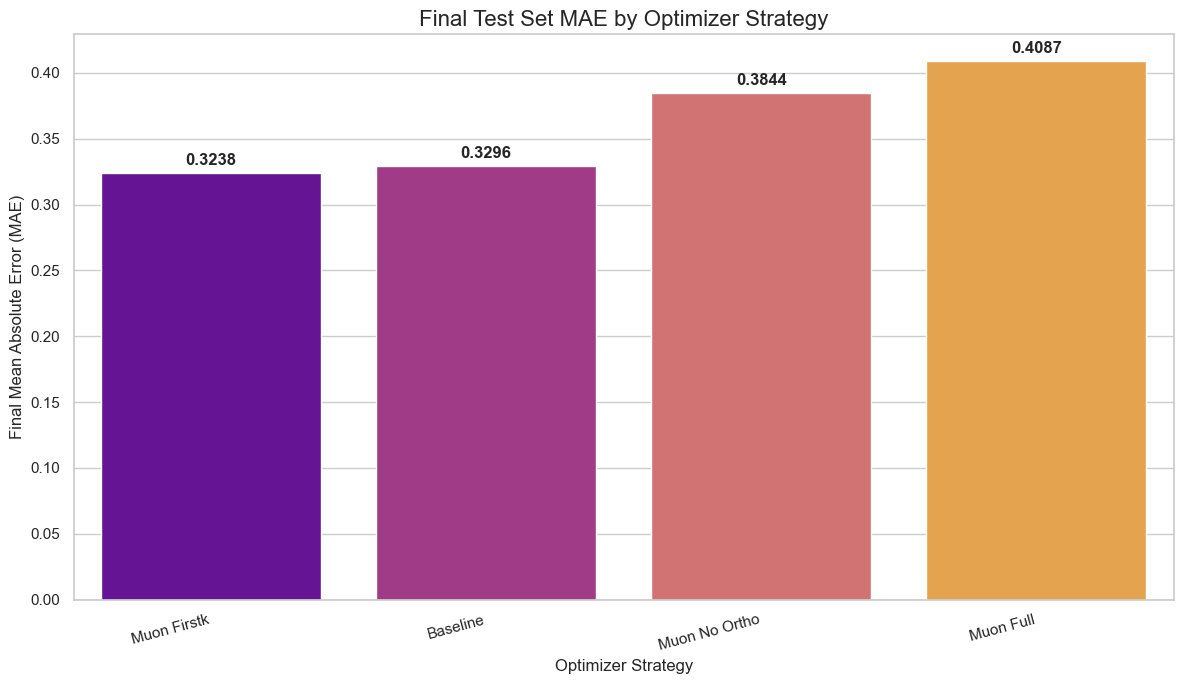

In [6]:
# Clean up run names for plotting
df_test['run_label'] = df_test['run'].str.replace('omat24_', '').str.replace('_', ' ').str.title()

# Create the bar plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=df_test.sort_values("Final Test MAE"), 
                 x='run_label', y='Final Test MAE', 
                 palette='plasma')

ax.set_title('Final Test Set MAE by Optimizer Strategy', fontsize=16)
ax.set_xlabel('Optimizer Strategy', fontsize=12)
ax.set_ylabel('Final Mean Absolute Error (MAE)', fontsize=12)
plt.xticks(rotation=15, ha='right')

# Add annotations to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


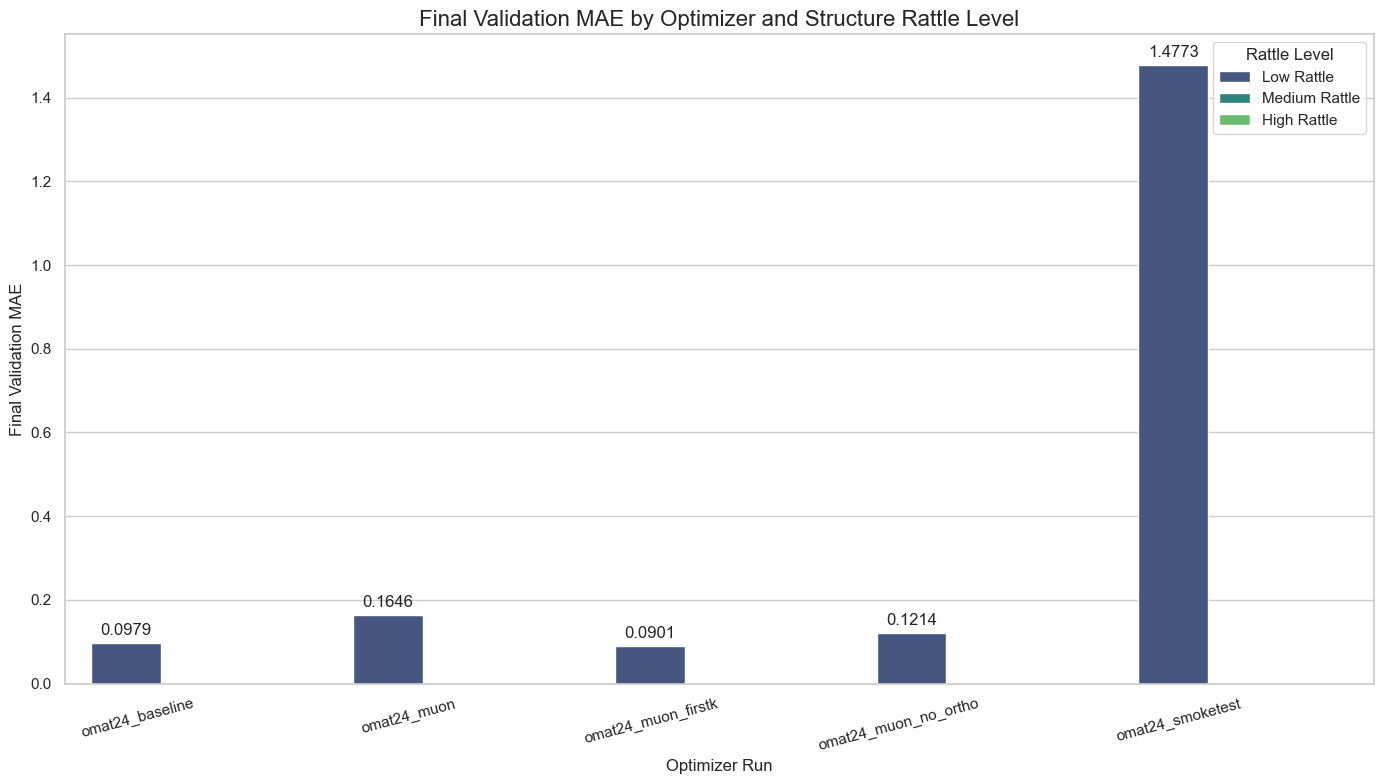

In [7]:
# Extract the final epoch metrics for each run
final_metrics = df_full.groupby('run').last().reset_index()

# Select only the rattle MAE columns
rattle_mae_cols = ['val_mae_low_rattle', 'val_mae_medium_rattle', 'val_mae_high_rattle']
plot_data = final_metrics[['run'] + rattle_mae_cols]

# Melt the dataframe to make it suitable for a bar plot
plot_data_melted = plot_data.melt(id_vars='run', var_name='Rattle Level', value_name='Final MAE')

# Clean up the names for the plot
plot_data_melted['Rattle Level'] = plot_data_melted['Rattle Level'].str.replace('val_mae_', '').str.replace('_', ' ').str.title()

# Create the bar plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=plot_data_melted, x='run', y='Final MAE', hue='Rattle Level', palette='viridis')

ax.set_title('Final Validation MAE by Optimizer and Structure Rattle Level', fontsize=16)
ax.set_xlabel('Optimizer Run', fontsize=12)
ax.set_ylabel('Final Validation MAE', fontsize=12)
plt.xticks(rotation=15, ha='right')

# Add annotations to the bars
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.4f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

plt.tight_layout()
plt.show()
